In [ ]:
!pip install poutyne
!pip install timm

Mounted at /content/drive
Number of classes: 8
Number of training samples: 6401
Number of testing samples: 1601


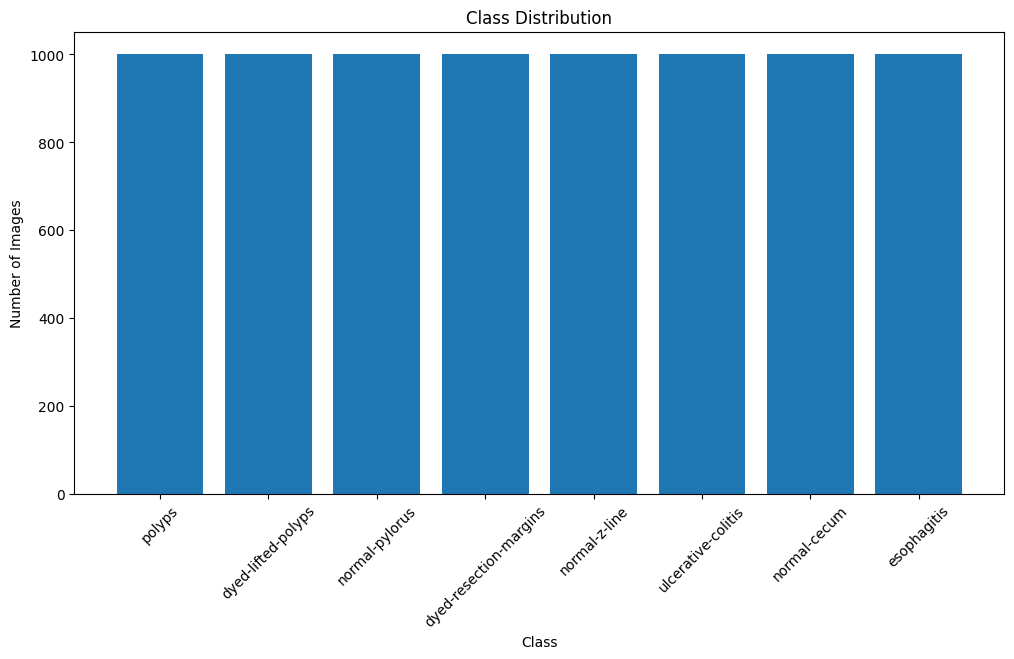

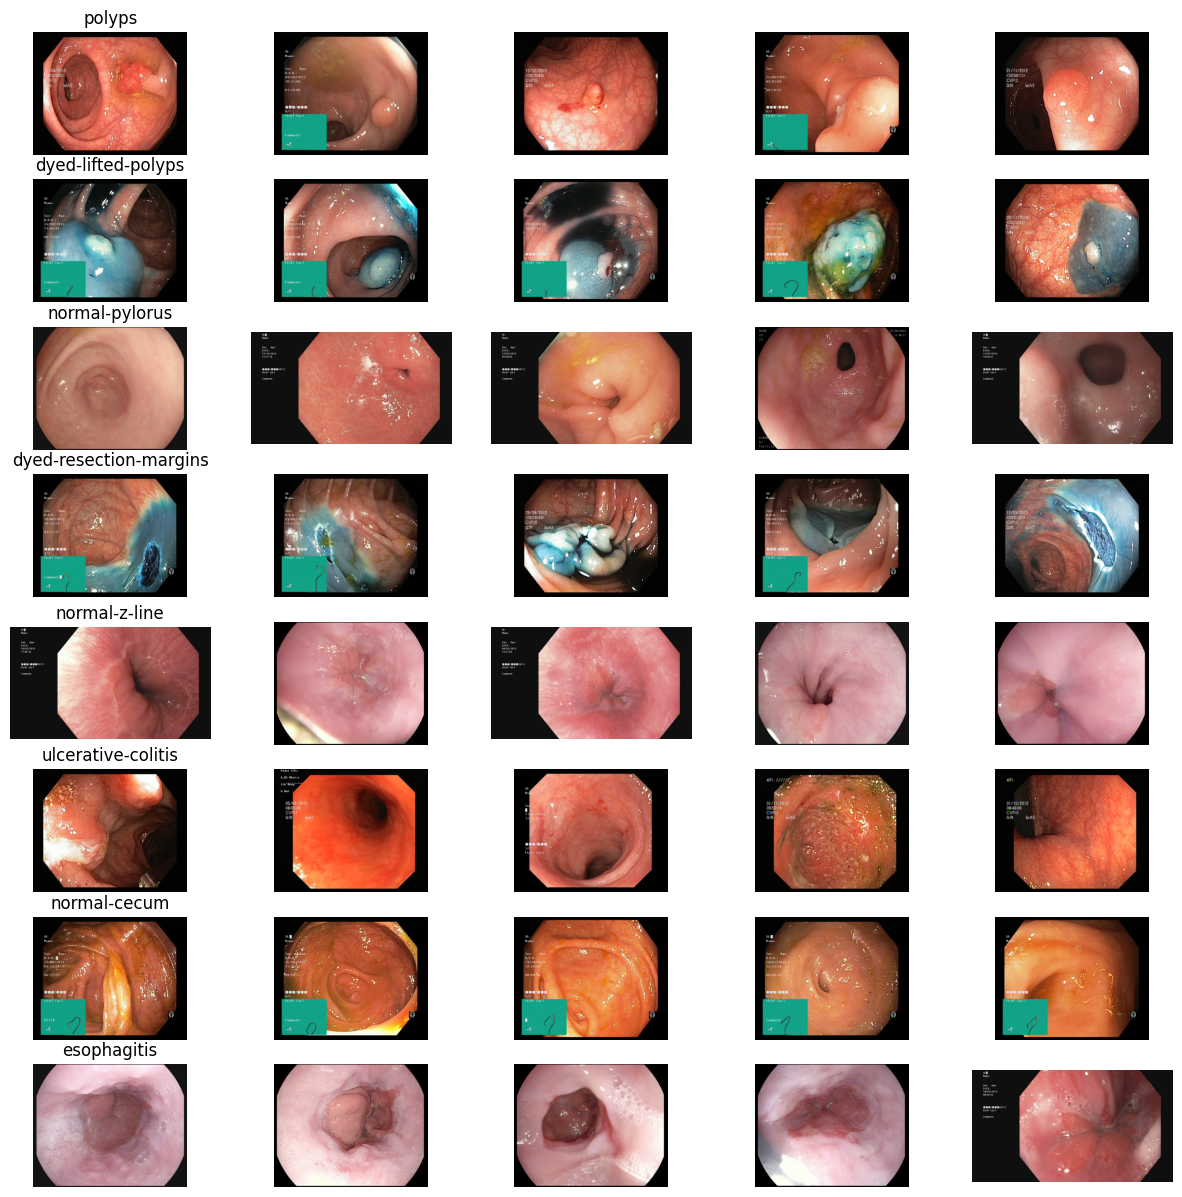

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from poutyne.framework import Model, Callback
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from google.colab import drive
import timm

drive.mount('/content/drive', force_remount=True)
dataset_root = '/content/drive/My Drive/kvasir-dataset-v2/kvasir-dataset-v2'

# Define data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a custom dataset
full_dataset = ImageFolder(dataset_root, transform=None)

# Split the dataset into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Apply transforms to train and test datasets
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# EDA (Exploratory Data Analysis)
num_classes = len(train_dataset.dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

class_names = os.listdir(dataset_root)

# Count the number of images in each class
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(dataset_root, class_name)
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

# Plot a bar chart to visualize class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# Display sample images from each class
import random
from torchvision.utils import make_grid

def display_sample_images(data_loader, class_names, num_samples=5):
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}

    # Create a subplot for each class
    fig, axs = plt.subplots(len(class_names), num_samples, figsize=(15, 15))

    for class_name in class_names:
        class_index = class_indices[class_name]
        class_path = os.path.join(dataset_root, class_name)

        # Get random samples from the class
        random_samples = random.sample(os.listdir(class_path), num_samples)

        for i, sample_file in enumerate(random_samples):
            sample_image_path = os.path.join(class_path, sample_file)
            sample_image = plt.imread(sample_image_path)

            axs[class_index, i].imshow(sample_image)
            axs[class_index, i].axis('off')
            if i == 0:
                axs[class_index, i].set_title(class_name)

    plt.show()

# Display sample images from each class
display_sample_images(train_loader, class_names, num_samples=5)

In [3]:
# Define the FastViT model
class FastViT(nn.Module):
    def __init__(self, num_classes):
        super(FastViT, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_features = self.model.head.in_features
        self.model.head = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FastViT(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Create a Poutyne Model
model = Model(model, optimizer, criterion, device=device)

import poutyne

# Define a callback for early stopping
early_stopping = poutyne.EarlyStopping(monitor="val_loss", patience=5, verbose=True)

In [4]:
# Train the model with the custom callback
model.fit_generator(
    train_loader,
    test_loader,
    epochs=10,
    callbacks=[early_stopping],  # Add the custom callback
)

# Evaluate the model
model.evaluate_generator(test_loader)

Epoch:  1/10 Train steps: 201 Val steps: 51 36m52.33s loss: 0.495813 val_loss: 0.555807
Epoch:  2/10 Train steps: 201 Val steps: 51 6m23.33s loss: 0.226143 val_loss: 0.248052
Epoch:  3/10 Train steps: 201 Val steps: 51 6m26.42s loss: 0.152769 val_loss: 0.221502
Epoch:  4/10 Train steps: 201 Val steps: 51 6m24.75s loss: 0.122624 val_loss: 0.519247
Epoch:  5/10 Train steps: 201 Val steps: 51 6m21.89s loss: 0.095356 val_loss: 0.427510
Epoch:  6/10 Train steps: 201 Val steps: 51 6m19.58s loss: 0.076061 val_loss: 0.371097
Epoch:  7/10 Train steps: 201 Val steps: 51 6m15.86s loss: 0.073999 val_loss: 0.357400
Epoch:  8/10 Train steps: 201 Val steps: 51 6m17.69s loss: 0.053168 val_loss: 0.337293
Epoch 8: early stopping
Test steps: 51 45.14s test_loss: 0.337293                               


0.3372933251421426

In [8]:
# Save the trained model
model.save_weights('fastvit_model_weights.pth')

In [15]:
loss, pred_y, true_y = model.evaluate_generator(
    test_loader, return_pred=True, return_ground_truth=True
)

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_y, pred_y.argmax(axis=1))
f1 = f1_score(true_y, pred_y.argmax(axis=1), average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_y, pred_y.argmax(axis=1))

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print classification report
class_report = classification_report(true_y, pred_y.argmax(axis=1), target_names=class_names)
print("\nClassification Report:")
print(class_report)

Test steps: 51 46.70s test_loss: 0.337293                               
Accuracy: 0.8944
F1 Score: 0.8943
Confusion Matrix:
[[184  10   0   0   0   0   0   0]
 [ 29 174   0   0   0   0   0   0]
 [  0   0 141   0   0  53   0   1]
 [  1   0   0 190   0   0  17   4]
 [  0   0   0   0 208   1   1   0]
 [  0   0  17   0   2 179   0   0]
 [  1   0   0   5   4   1 180   3]
 [  0   1   0   3   0   0  15 176]]

Classification Report:
                        precision    recall  f1-score   support

                polyps       0.86      0.95      0.90       194
    dyed-lifted-polyps       0.94      0.86      0.90       203
        normal-pylorus       0.89      0.72      0.80       195
dyed-resection-margins       0.96      0.90      0.93       212
         normal-z-line       0.97      0.99      0.98       210
    ulcerative-colitis       0.76      0.90      0.83       198
          normal-cecum       0.85      0.93      0.88       194
           esophagitis       0.96      0.90      0.93    